# Exercise: Distributed Monte Carlo

Calculate the value of $\pi$ through parallel direct Monte Carlo.

A unit circle is inscribed inside a unit square with side length 2 (from -1 to 1). The area of the circle is $\pi$, the area of the square is 4, and the ratio is $\pi/4$. This means that, if you throw $N$ darts randomly at the square, approximately $M=N\pi/4$ of those darts will land inside the unit circle.

Throw darts randomly at a unit square and count how many of them ($M$) landed inside of a unit circle. Approximate $\pi \approx 4M/N$. Visualization:

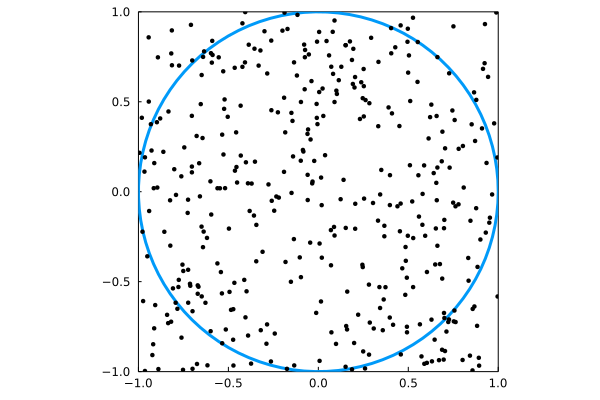

In [3]:
using Plots, Distributions

# plot circle
circlepts = Plots.partialcircle(0, 2π, 100)
plot(circlepts, aspect_ratio=:equal, xlims=(-1,1), ylims=(-1,1), legend=false, lw=3, grid=false, frame=:box)

# plot darts
N = 400
d = Uniform(-1, 1)
scatter!(rand(d, N), rand(d, N), ms=2.5, color=:black)

### Tasks

1. Write a function `compute_pi(N::Int)` which computes $\pi$ by throwing $N$ darts as described above.


2. Based on 1), write a function `compute_pi_parallel(N::Int, nworkers::Int)` which does the same but divides the work among `ncores` processes.


3. Benchmark and compare the methods from 1) and 2).


4. Write a function `compute_pi_multiple(Ns::Vector{Int})` which computes $\pi$ for all given $N$ values. The function should be serial and based on 1).


5. Write a function `compute_pi_multiple_parallel(Ns::Vector{Int})` which does the same but in parallel. The function should also be based on 1).


6. Benchmark and compare the methods from 4) and 5).


7. Calculate $\pi$ estimates for `Ns = ceil.(Int, exp10.(range(1, stop=8, length=50)))`. Plot $\pi$ vs $N$ on a semi-log plot.


8. Bonus: Write a function `compute_pi_multiple_double_parallel(Ns::Vector{Int})` which computes $\pi$ for all given $N$ values. The calculation should be as parallel as possible. Multiple different values of $N$ should be calculated at the same time and every one of those calculations should be parallel as well.

A reasonable value could be `N = 10_000_000`.

In [74]:
@everywhere function compute_pi(N::Int)
    d = Uniform(-1, 1)
    r = rand(d, (2, N))
    n = 0
    m = 0
    @inbounds for i in 1:N
        if (r[1,i]^2 + r[2,i]^2) <= 1 
            n += 1
        end
        m += 1
    end
    return 4 * n / m
end 

In [39]:
compute_pi(N*10)

3.18

In [59]:
nworkers() == 1 ? addprocs(4) : nothing;

In [66]:
@everywhere using Hwloc, Distributions, Distributed
d = Uniform(-1, 1)
N_CORE = Hwloc.num_physical_cores()

@everywhere function count_circle(N::Int, d::Uniform)
    n = 0
    @inbounds for i in 1:N
        if (rand(d) + rand(d)) <= 1 
            n += 1
        end
    end
    return n 
end

In [67]:
function compute_pi_parallel(N::Int, n_workers::Int)
    n_circle = @distributed (+) for i in 1:n_workers
            count_circle(ceil(Int, N/n_workers), Uniform(-1, 1))
    end
    return 4*n_circle/N
end

compute_pi_parallel (generic function with 1 method)

In [68]:
compute_pi_parallel(10000, N_CORE)

3.5136

In [69]:
nworkers()

4

In [70]:
using BenchmarkTools

@btime compute_pi(10_000_000)
@btime compute_pi_parallel(10_000_000, N_CORE)

  102.355 ms (2 allocations: 152.59 MiB)
  10.463 ms (282 allocations: 12.94 KiB)


3.5001188

In [76]:
function compute_pi_multiple(Ns::Vector{Int})
    Pis = zeros(length(Ns))
    for i in 1:length(Ns)
        Pis[i] = compute_pi(Ns[i])
    end
    return Pis
end

compute_pi_multiple (generic function with 1 method)

In [77]:
compute_pi_multiple([100, 1000, 10000])

3-element Vector{Float64}:
 3.44
 3.152
 3.1156

In [78]:
function compute_pi_multiple_parallel(Ns::Vector{Int})
    Pis = pmap(compute_pi, Ns)
    return Pis
end

compute_pi_multiple_parallel (generic function with 1 method)

In [79]:
compute_pi_multiple_parallel([100, 1000, 10000])

3-element Vector{Float64}:
 3.16
 3.124
 3.1492

In [80]:
some_Ns = [1_000_000, 2_000_000, 3_000_000, 4_000_000, 10_000_000]

@btime compute_pi_multiple($some_Ns)
@btime compute_pi_multiple_parallel($some_Ns)

  197.674 ms (11 allocations: 305.18 MiB)
  122.711 ms (293 allocations: 11.11 KiB)


5-element Vector{Float64}:
 3.142724
 3.140616
 3.1435866666666668
 3.141916
 3.1422572